# Calibration of models parameters: SPX
### based on European Call options
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')
import time

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

random.seed(120)

Let's start retrieving historical prices for **european call** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. The options that will be used in this notebook are all Out-Of-The-Money (OTM) options.

In [3]:
df_call = pd.read_csv('../../data/SPX/OPT16_SPX_CALLS_restricted.csv')
print(f'NUM OF CALL OPTS: {df_call.shape[0]}')
print(df_call.head(5))

NUM OF CALL OPTS: 45
   QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE   C_BID   C_ASK  STRIKE     C_IV  \
0  2016-01-20          1859.48  2017-01-20  470.29  474.59  1400.0  0.26759   
1  2016-01-20          1859.48  2017-01-20  449.20  453.50  1425.0  0.26681   
2  2016-01-20          1859.48  2017-01-20  428.40  432.60  1450.0  0.26499   
3  2016-01-20          1859.48  2017-01-20  407.90  412.00  1475.0  0.26333   
4  2016-01-20          1859.48  2017-01-20  387.60  391.70  1500.0  0.26134   

   MONEYNESS  
0       0.75  
1       0.77  
2       0.78  
3       0.79  
4       0.81  


The dataframe **df_calls** contains 45 options, having a moneyness in the range $[0.75, 1.35]$. For our purpose, using the $50\%$ of this DFs is enough and can lead to very good results. Thus, we sample the rows and then reformulate the dataframe adding **Midpoint** and **Spread** columns.

In [4]:
calls = df_call.sample(frac=0.5, replace=False).sort_index().reset_index(drop=True)
calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']

q = 0           # dividend yield
r = 0.03        # risk-free interest rate
sigma = 0.3     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
call_strikes = calls['STRIKE']    # array of K for call options
exercise = 'european'

call_prices = calls['C_Midpoint']

The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. These parameters serve only as initialization. Best fitting parameters will be calibrated later and will be used to correctly price the options according to each model.

In [5]:
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=0.15, lambd=0.5, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.6, eta1=12, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.3, exercise=exercise)

## Implied volatility
The function belows implements $3$ methods to comcalle implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [8]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if disp:
        return -1

The following code snippet computes the implied volatility associated to each **call** contract using the Black-Scholes inversion. **BS inversion** consists of minimizing the distance between the option price estimated by Black-Scholes formula and the market price given by the dataframe. 

Implied volatilities of market prices (calls):
S0 = 1859.48
K = 2275.0, IV = 0.1446
K = 2300.0, IV = 0.1418
K = 2325.0, IV = 0.1395
K = 2375.0, IV = 0.1359
K = 2425.0, IV = 0.1295
K = 2500.0, IV = 0.1344


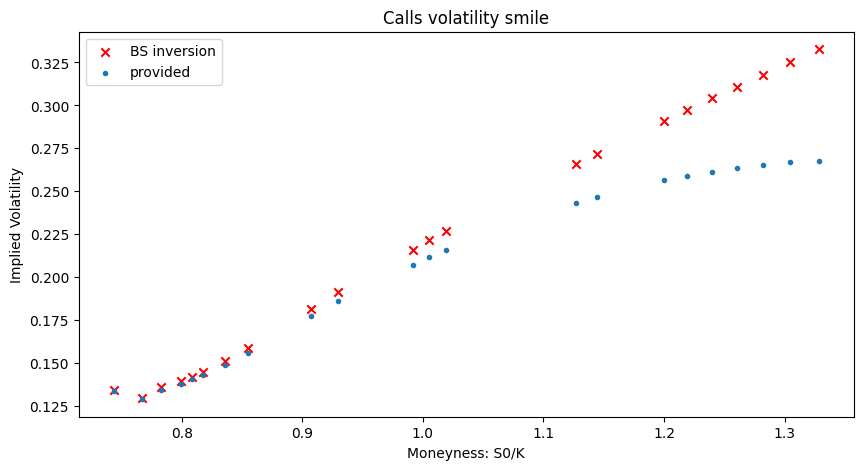

In [9]:
IV_market = []
for i in range(len(call_prices)):
    IV_market.append(implied_volatility(call_prices[i], S=S0, strike=call_strikes[i], t = T, rate=0.03, q = 0.05, type_o='call', method='fsolve'))

print(f'Implied volatilities of market prices (calls):\nS0 = {S0}')
for a,b in zip(call_strikes.tail(6), IV_market[-6:]):
    print(f'K = {a}, IV = {round(b, 4)}')

# Plot market implied volatilities w.r.t. log moneyness
x = (S0/call_strikes)
IV_filtered = [iv for iv in IV_market if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market, x) if iv != -1]

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(x, IV_market, marker='x', label='BS inversion', color='red')
ax1.scatter(x, calls['C_IV'], marker='.', label='provided')
ax1.set_xlabel('Moneyness: S0/K'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('Calls volatility smile')
ax1.legend(); plt.show()


##  Weighted Calibration (call options)
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i^2 },$$ $P_i$ are the market prices and $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perform this optimization problem, many numerical methods can be used. In particular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works with bounds. The default algorithm is [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region). The [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) has been tried as well, to test the optimization problem without setting boundaries, but the results don't make any sense.
2. **Least-Squares**, a constrained minimization problem which uses Trust region reflective method by default. This method is the most indicated to solve the non-linear least squares optimization problem of our purpose.
All the optimizations are carried out by initializing a starting point as the array $x_0 = [params]$ and setting feasible bounds.


In [10]:
call_spreads = calls['C_Spread']
c_weights = 1/ call_spreads**2

### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of call options.

In [11]:
x0 = 0.5
bounds = [1e-5, 2]

def f_BlackScholes_calls(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise=exercise)
    return BS.closed_formula_call(x)

res1_calls = scpo.curve_fit(f_BlackScholes_calls, call_strikes, call_prices, p0 = x0, bounds=bounds, sigma=c_weights)
sigw_p = round(res1_calls[0][0],4)

In [12]:
def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise=exercise)
    sq_err = np.sum(c_weights* (BS.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

result_p = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=1)
opt_sigma_p = result_p.x[0]

`ftol` termination condition is satisfied.
Function evaluations 23, initial cost 1.3560e+10, final cost 3.0264e+04, first-order optimality 8.41e+00.


In [13]:
print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')
print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {opt_sigma_p} \t {round(opt_sigma_p*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.1324 	 13.24%
METHOD 2: LEAST-SQUARES (trf)
> Calibrated Volatility from Calls [σ] = 0.13290630220347174 	 13.29%


In [18]:
calls_bs_params_spx = opt_sigma_p
%store calls_bs_params_spx

Stored 'calls_bs_params_spx' (float64)


### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [14]:
x0 = [0.15,  0.2, -0.05,  0.01]  # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -5, 1e-5], [2, 5, 5, 2] )

In [15]:
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)

start1=time.time()
mert1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=call_spreads)
end1=time.time()

mert_params1 = [round(p,4) for p in mert1[0][:4]]

##### Method 2. Least-squares

In [16]:
x0 = [0.15,  0.5, -0.05,  0.1]      # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -10, 0], [2, np.inf, 10, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum(c_weights*(M.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

start2 = time.time()
mert2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=1)
end2 = time.time()

mert_params2 = [round(p,4) for p in mert2.x[:4]]

The maximum number of function evaluations is exceeded.
Function evaluations 400, initial cost 4.4191e+05, final cost 3.0107e+04, first-order optimality 2.28e+03.


In [19]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(mert1[0][0],4)} \t {round(mert1[0][0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert1[0][1],2))
print('> Calibrated Jump Mean = ', round(mert1[0][2],2))
print('> Calibrated Jump St. dev.  = ', round(mert1[0][3],5))
print(f'ELAPSED TIME: {round(end1-start1,2)} sec')

print('\nMETHOD 1: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params2[0]} \t {round(mert_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params2[1],2))
print('> Calibrated Jump Mean = ', round(mert_params2[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params2[3],3))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.0692 	 6.92%
> Calibrated Jump intensity [λ] =  5.0
> Calibrated Jump Mean =  -0.05
> Calibrated Jump St. dev.  =  1e-05
ELAPSED TIME: 8.75 sec

METHOD 1: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1246 	 12.46%
> Calibrated Jump intensity [λ] =  0.49
> Calibrated Jump Mean =  -0.049
> Calibrated Jump St. dev.  =  0.053
TIME ELAPSED:  67.35 sec


In [20]:
print(mert_params1)
print(mert_params2)
calls_mert_params_spx = mert_params2
%store calls_mert_params_spx

[0.0692, 5.0, -0.0529, 0.0]
[0.1246, 0.4889, -0.0493, 0.0528]
Stored 'calls_mert_params_spx' (list)


### Kou Jump Diffusion


In [22]:
x0 = [0.2, 0.5, 0.5, 8, 10] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-2, 1e-1, 0, 4, 4], [1, 4, 1, 15, 20] )

##### Method 1. TRF (Bounds)

In [23]:
# def f_Kou(x, sigma, lambd, p, eta1, eta2):
#     KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
#     return KouJD.closed_formula_call(x)
#
# start1 = time.time()
# kou1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=c_weights)
# end1 = time.time()
#
# kou_params1 = [round(p,4) for p in kou1[0][:5]]

##### Method 2. LEAST SQUARES (With Bounds)

In [24]:
# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(c_weights*(KOU.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=1)
end2=time.time()

The maximum number of function evaluations is exceeded.
Function evaluations 500, initial cost 3.0997e+07, final cost 3.9946e+04, first-order optimality 1.54e+04.


In [25]:
kou_params2 = [round(p,4) for p in kou2.x[:5]]

In [26]:
# print('WEIGHTED OPT: CURVE_FIT (trf)')
# print(f'> Calibrated Volatlity [σ] = {kou_params1[0]} \t {kou_params1[0] * 100}%')
# print('> Calibrated Jump intensity [λ] = ', kou_params1[1])
# print(f'> Calibrated Upward Jump probability [p] = {kou_params1[2]}, [q] = {round(1 - kou_params1[2], 2)}')
# print('> Calibrated Rate of Exp. 1  [η_1] = ', kou_params1[3])
# print('> Calibrated Rate of Exp. 2  [η_2] = ', kou_params1[4])
# print(f'TIME ELAPSED: {end1-start1} sec')

In [27]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params2[0],4)} \t {round(kou_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params2[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params2[2],2)}, [q] = {round(1-kou_params2[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params2[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params2[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.1215 	 12.15%
> Calibrated Jump intensity [λ] =  0.2
> Calibrated Upward Jump probability [p] = 0.18, [q] = 0.82
> Calibrated Rate of Exp. 1  [η_1] =  8.71
> Calibrated Rate of Exp. 2  [η_2] =  10.29
TIME ELAPSED:  7892.16 sec


In [22]:
calls_kou_params_spx = kou_params2
%store calls_kou_params_spx
print(kou_params2)

[0.1192, 0.3314, 0.0675, 8.8496, 10.1685]


### Variance Gamma


In [23]:
x0 = [0.25, -0.2, 0.2]   # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [1, 5, 5] )

##### Method 1. CURVE FIT (Bounds)

In [24]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

start1 = time.time()
vg1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=c_weights)
end1 = time.time()

vg_params1 = [round(p,4) for p in vg1[0][:3]]

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:230: RuntimeWarning: overflow encountered in exp
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:230: RuntimeWarning: invalid value encountered in scalar divide
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:230: RuntimeWarning: invalid value encountered in scalar multiply
  f = lambda u: ss.norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * np.exp((g - 1) * np.log(u)) * np.exp(
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\VGpricer.py:232: IntegrationWarning: The maximum number of subdivisions (50) has been achi

##### Method 2. LEAST-SQUARES (Trust Region Reflective, Bounds)

In [25]:
def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in strikes:
        prices.append(VG.closed_formula_call(k))
    sq_err = np.sum(c_weights*(prices - mkt_prices)**2)
    return sq_err

start2=time.time()
vg2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=1, loss='soft_l1')
end2=time.time()

vg_params2 = [round(p,4) for p in vg2.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0835e+04                                    3.69e+05    
       1              3         3.0366e+03      1.78e+04       3.04e-01       2.04e+04    
       2              4         2.6787e+02      2.77e+03       1.24e-01       1.35e+04    
       3              7         1.7313e+02      9.47e+01       9.91e-03       3.65e+03    
       4              9         1.6652e+02      6.61e+00       3.49e-03       4.26e+03    
       5             10         1.6148e+02      5.04e+00       5.66e-03       4.24e+03    
       6             11         1.5196e+02      9.52e+00       1.18e-02       3.80e+03    
       7             12         1.3830e+02      1.37e+01       2.31e-02       2.82e+03    
       8             13         1.2557e+02      1.27e+01       1.92e-02       2.27e+03    
       9             14         1.1853e+02      7.04e+00       4.67e-02       1.99e+03    

In [26]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params1[0]}, \t {round(vg_params1[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params1[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params1[2])
print(f'TIME ELAPSED:  {round(end1-start1,2)} sec')

print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params2[0]}, \t {round(vg_params2[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params2[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params2[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.0055, 	 0.55%
> Calibrated mean rate gamma process [θ] =  -0.8304
> Calibrated variance rate gamma process [v]=  0.0294
TIME ELAPSED:  144.11 sec
METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1259, 	 12.59%
> Calibrated mean rate gamma process [θ] =  0.1715
> Calibrated variance rate gamma process [v]=  0.1711
TIME ELAPSED:  347.39 sec


In [27]:
print(vg_params1)
print(vg_params2)
calls_vg_params_spx = vg_params2
%store calls_vg_params_spx

[0.0055, -0.8304, 0.0294]
[0.1259, 0.1715, 0.1711]


### Reprice options using calibrated parameters
Once we have calibrated all the models, we test our parameters calibration by repricing the original dataframe of options. The table contains all the **BID**, **ASK** and **MIDPOINT** prices. The calibration is well perfromed if the prices we obtain belong to the interval $[BID, ASK]$.

In [35]:
days = 252
paths = 1000

call_calib_prices = pd.DataFrame({
    'STRIKE': calls['STRIKE'],    # array of K for call options
    'MKT_BID': calls['C_BID'],
    'MKT_MID': calls['C_Midpoint'],
    'MKT_ASK': calls['C_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{call_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

    STRIKE  MKT_BID  MKT_MID  MKT_ASK
0   1450.0   428.40  430.500   432.60
1   1525.0   367.60  369.600   371.60
2   1600.0   309.29  311.240   313.19
3   1625.0   290.60  292.505   294.41
4   1650.0   272.29  274.200   276.11
5   1700.0   237.10  238.900   240.70
6   1725.0   220.00  221.855   223.71
7   1750.0   203.50  205.300   207.10
8   1800.0   171.80  173.500   175.20
9   1850.0   142.59  144.250   145.91
10  1925.0   103.00  104.550   106.10
11  1950.0    91.20   92.745    94.29
12  2000.0    70.00   71.455    72.91
13  2025.0    60.40   61.800    63.20
14  2125.0    29.70   30.900    32.10
15  2150.0    24.11   25.305    26.50
16  2200.0    15.21   16.255    17.30
17  2250.0     8.89    9.945    11.00
18  2350.0     2.44    3.470     4.50
19  2375.0     1.64    2.670     3.70
20  2400.0     1.05    2.080     3.11
21  2425.0     0.54    1.270     2.00


#### Merton Jump Diffusion model

In [36]:
#mert_params2 = [0.114, 0.4987, -0.0956, 0.0733]
sigma, lambd, meanJ, stdJ = mert_params2
MertonCAL = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton_CAL = MertonCAL.MertonPath(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton_CAL[-1]:
        payoffs.append(MertonCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(call_calib_prices))
merton_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = MertonCAL.closed_formula_call(call_strikes[index])

call_calib_prices['MERTON MC'] = merton_mc_prices
call_calib_prices['MERTON CF'] = merton_cf_prices

print(call_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK   MERTON MC   MERTON CF
0   1450.0   428.40  430.500   432.60  457.285283  456.517677
1   1525.0   367.60  369.600   371.60  399.058551  387.617720
2   1600.0   309.29  311.240   313.19  340.831819  321.425475
3   1625.0   290.60  292.505   294.41  321.422909  300.172844
4   1650.0   272.29  274.200   276.11  302.013998  279.411102
5   1700.0   237.10  238.900   240.70  263.196177  239.578306
6   1725.0   220.00  221.855   223.71  245.183910  220.617445
7   1750.0   203.50  205.300   207.10  228.201113  202.365501
8   1800.0   171.80  173.500   175.20  194.235519  168.187220
9   1850.0   142.59  144.250   145.91  171.929460  137.391290
10  1925.0   103.00  104.550   106.10  142.816094   98.029192
11  1950.0    91.20   92.745    94.29  133.111639   86.773320
12  2000.0    70.00   71.455    72.91  113.702728   67.012334
13  2025.0    60.40   61.800    63.20  104.306732   58.460897
14  2125.0    29.70   30.900    32.10   75.193366   32.246576
15  2150

In [68]:
# kou_params2 = [0.1192, 0.2314, 0.1675, 8.8496, 10.1685]
sigma, lambd, p, eta1, eta2 = kou_params2
KouCAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_CAL = KouCAL.KouPath(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou_CAL[-1]:
        payoffs.append(KouCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(call_calib_prices))
kou_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = KouCAL.closed_formula_call(call_strikes[index])

call_calib_prices['KOU MC'] = kou_mc_prices
call_calib_prices['KOU CF'] = kou_cf_prices

selection = [0,1,2,3,6,7]
print(call_calib_prices.iloc[:, selection])

    STRIKE  MKT_BID  MKT_MID  MKT_ASK      KOU MC      KOU CF
0   1450.0   428.40  430.500   432.60  445.253616  455.788336
1   1525.0   367.60  369.600   371.60  372.470201  385.921796
2   1600.0   309.29  311.240   313.19  299.686786  318.481675
3   1625.0   290.60  292.505   294.41  275.425647  296.797584
4   1650.0   272.29  274.200   276.11  251.164509  275.619836
5   1700.0   237.10  238.900   240.70  208.709124  235.061355
6   1725.0   220.00  221.855   223.71  189.300214  215.818942
7   1750.0   203.50  205.300   207.10  172.128167  197.355484
8   1800.0   171.80  173.500   175.20  141.856617  162.995703
9   1850.0   142.59  144.250   145.91  116.728751  132.359580
10  1925.0   103.00  104.550   106.10   87.605286   93.812697
11  1950.0    91.20   92.745    94.29   79.429777   82.945845
12  2000.0    70.00   71.455    72.91   64.873094   64.065970
13  2025.0    60.40   61.800    63.20   57.594753   55.980991
14  2125.0    29.70   30.900    32.10   37.323712   31.543592
15  2150

In [69]:
# vg_params2 =[0.1259, 0.1715, 0.1711]
sigm, theta, nu = vg_params2
VGCAL = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
SVarGamma_CAL = VGCAL.VarianceGammaPath2(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVarGamma_CAL[-1]:
        payoffs.append(VGCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(call_calib_prices))
vg_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VGCAL.closed_formula_call(call_strikes[index])

call_calib_prices['VG MC'] = vg_mc_prices
call_calib_prices['VG CF'] = vg_cf_prices

selection = [0,1,2,3,8,9]
print(call_calib_prices.iloc[:, selection])

    STRIKE  MKT_BID  MKT_MID  MKT_ASK       VG MC       VG CF
0   1450.0   428.40  430.500   432.60  586.852010  457.361482
1   1525.0   367.60  369.600   371.60  514.068595  388.858239
2   1600.0   309.29  311.240   313.19  441.285180  323.094241
3   1625.0   290.60  292.505   294.41  417.024041  301.973756
4   1650.0   272.29  274.200   276.11  392.762903  281.329870
5   1700.0   237.10  238.900   240.70  344.240626  241.664478
6   1725.0   220.00  221.855   223.71  319.979488  222.740290
7   1750.0   203.50  205.300   207.10  295.718350  204.485829
8   1800.0   171.80  173.500   175.20  250.002962  170.168138
9   1850.0   142.59  144.250   145.91  208.766195  139.043824
10  1925.0   103.00  104.550   106.10  165.820829   98.888465
11  1950.0    91.20   92.745    94.29  153.690260   87.318094
12  2000.0    70.00   71.455    72.91  129.429122   66.916692
13  2025.0    60.40   61.800    63.20  119.441828   58.062199
14  2125.0    29.70   30.900    32.10   85.073896   30.968708
15  2150

In [70]:
print(call_calib_prices.head(5))

    STRIKE  MKT_BID  MKT_MID  MKT_ASK   MERTON MC   MERTON CF      KOU MC   
0   1450.0   428.40  430.500   432.60  457.285283  456.517677  445.253616  \
1   1525.0   367.60  369.600   371.60  399.058551  387.617720  372.470201   
2   1600.0   309.29  311.240   313.19  340.831819  321.425475  299.686786   
3   1625.0   290.60  292.505   294.41  321.422909  300.172844  275.425647   
4   1650.0   272.29  274.200   276.11  302.013998  279.411102  251.164509   
5   1700.0   237.10  238.900   240.70  263.196177  239.578306  208.709124   
6   1725.0   220.00  221.855   223.71  245.183910  220.617445  189.300214   
7   1750.0   203.50  205.300   207.10  228.201113  202.365501  172.128167   
8   1800.0   171.80  173.500   175.20  194.235519  168.187220  141.856617   
9   1850.0   142.59  144.250   145.91  171.929460  137.391290  116.728751   
10  1925.0   103.00  104.550   106.10  142.816094   98.029192   87.605286   
11  1950.0    91.20   92.745    94.29  133.111639   86.773320   79.429777   

### Visualize calibration results

#### Closed Formulas Option pricing

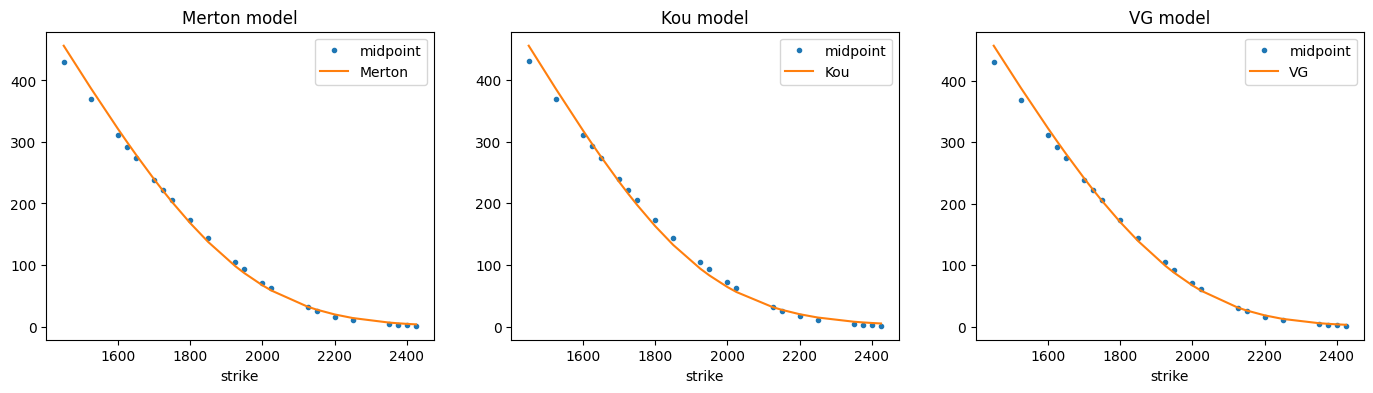

In [71]:
fig, ax = plt.subplots(ncols = 1, figsize=(17, 4))
ax[0].plot(call_strikes, merton_cf_prices, label="Merton")
ax[1].plot(call_strikes, kou_cf_prices, label="Kou")
ax[2].plot(call_strikes, vg_cf_prices, label="VG")
ax[0].set_title("Merton model. Closed formulas pricing"); ax[1].set_title("Kou model. Closed formulas pricing"); ax[2].set_title("VG model. Closed formulas pricing")
for i in range(3):
    ax[i].plot(call_strikes, call_prices, ".", label="midpoint")
    ax[i].set_xlabel("strike")
    ax[i].legend(); ax[i].grid()
plt.show()

#### Monte Carlo option pricing

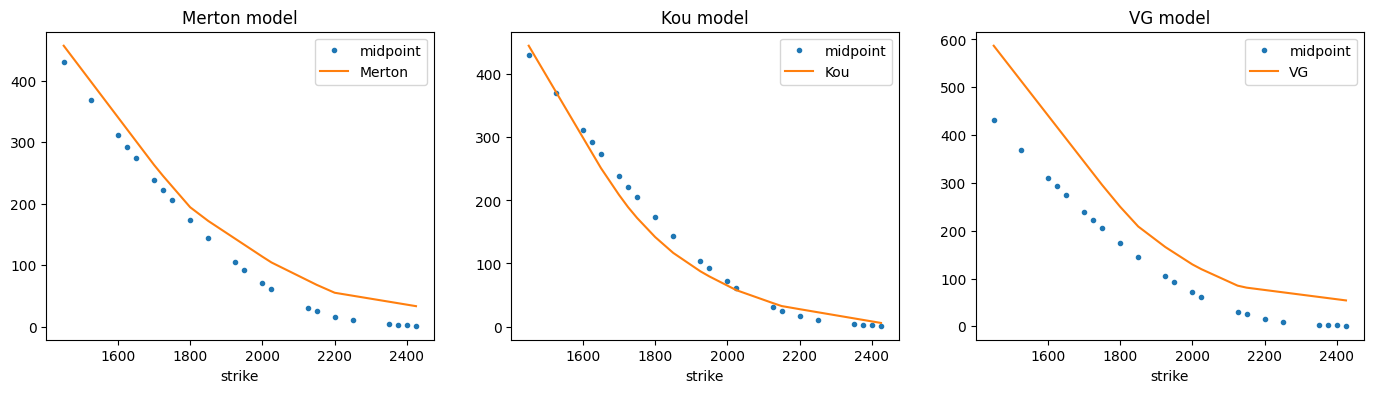

In [72]:
fig, ax = plt.subplots(ncols=3, figsize=(17, 4))

ax[0].plot(call_strikes, merton_mc_prices, label="Merton")
ax[1].plot(call_strikes, kou_mc_prices, label="Kou")
ax[2].plot(call_strikes, vg_mc_prices, label="VG")
ax[0].set_title("Merton model. Monte Carlo pricing"); ax[1].set_title("Kou model. Monte Carlo pricing"); ax[2].set_title("VG model. Monte Carlo pricing")

for i in range(3): 
    ax[i].plot(call_strikes, call_prices, ".", label="midpoint")
    ax[i].set_xlabel("strike")
    x[i].legend(); ax[i].grid()

plt.show()